In [1]:
import torch
import torch.nn as nn
import os
import logging
import numpy as np
from tqdm.auto import tqdm
from Model import Patchify, ExtraMAEDecoder, ExtraMAEEncoder, ExtraMAE
from util import random_indexes, take_indexes
from einops import repeat, rearrange
import matplotlib.pyplot as plt
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration

from accelerate import DistributedDataParallelKwargs
from safetensors.torch import load_model
from ai4ha.util import instantiate_from_config
from diffusers.optimization import get_scheduler
from ai4ha.util import instantiate_from_config, load_config, load_config_yaml
from ai4ha.util.train import get_most_recent_checkpoint

import pandas as pd

from ai4ha.data.series.SleepDataset import SleepDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

In [2]:
def sampling_MAE(
    device,
    model,
    dataset,
    nsamp,
):
    """ _Samplig from the ExtraMAE model_

    Passes random samples through the model, reconstructs the data and saves
    the samples and labels.
    """
    lsamples = []
    llabels = []
    lorig = []
    samples = np.random.randint(0, len(dataset), (nsamp, ))
    print(samples)
    for i in tqdm(samples):
        data, label = dataset[i]
        lorig.append(data)
        pred, mask = model(torch.tensor(data).unsqueeze(0).float().to(device))
        pred = pred.cpu().detach().numpy()
        mask = mask.cpu().detach().numpy()
        data = data * np.abs(mask - 1)
        pred_mask = pred * mask
        pred_mask = pred_mask + data
        lsamples.append(pred_mask)
        llabels.append(label)
    return np.concatenate(lsamples),  llabels

In [3]:
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

---

In [4]:
orig = SleepDataset(dir="/home/bejar/ssdstorage/Sleep", dataset='train',
                     padding=0, padalgo=None, norm='scale2')

Loading data from /home/bejar/ssdstorage/Sleep


/home/bejar/PycharmProjects/misiones/ai4ha/data/series/SleepDataset.py:27: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  dataset.append(np.swapaxes(data['x'], 1, 2))
/home/bejar/PycharmProjects/misiones/ai4ha/data/series/SleepDataset.py:28: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  labels.append(data['y'])


train
X_train shape is (137521, 1, 3000)
y_train shape is (137521,)
NClasses: 5 [0 1 2 3 4]
PAD=0 PADALGO=None NORM=scale2


In [5]:
odata = [d[0].squeeze() for d in orig]
sdata = np.array(odata)
length = 1000

In [6]:
datal = [int(d[1]) for d in orig]

In [38]:
model = 'EEG_Sleep-scale2-b32-AE-ExtraMAE_le4_ld8_he8_hd8_p10_m0.25_e64_mlT_nlT_pnormal-OPT-adamw-lr0.0001-SCplateau-f0.05-LS-MAE'
path = f'/home/bejar/bsc/misiones/Series/Models/ExtraMAE/logs/{model}/logs/losslog.csv'
loss = pd.read_csv(path)
loss.tail(3)

,MSEloss
338,0.007073
339,0.007076
340,0.007073


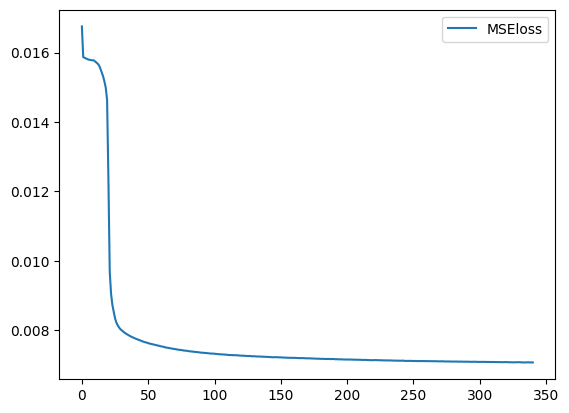

In [39]:
loss.iloc[-2000:].plot(y=['MSEloss']);

---

In [40]:
samples = np.load(f'/home/bejar/bsc/misiones/Series/Models/ExtraMAE/logs/{model}/samples/sampled_data.npz')

In [41]:
samp = samples['samples']
lab = samples['classes']
orig = samples['orig']
mask = samples['mask']


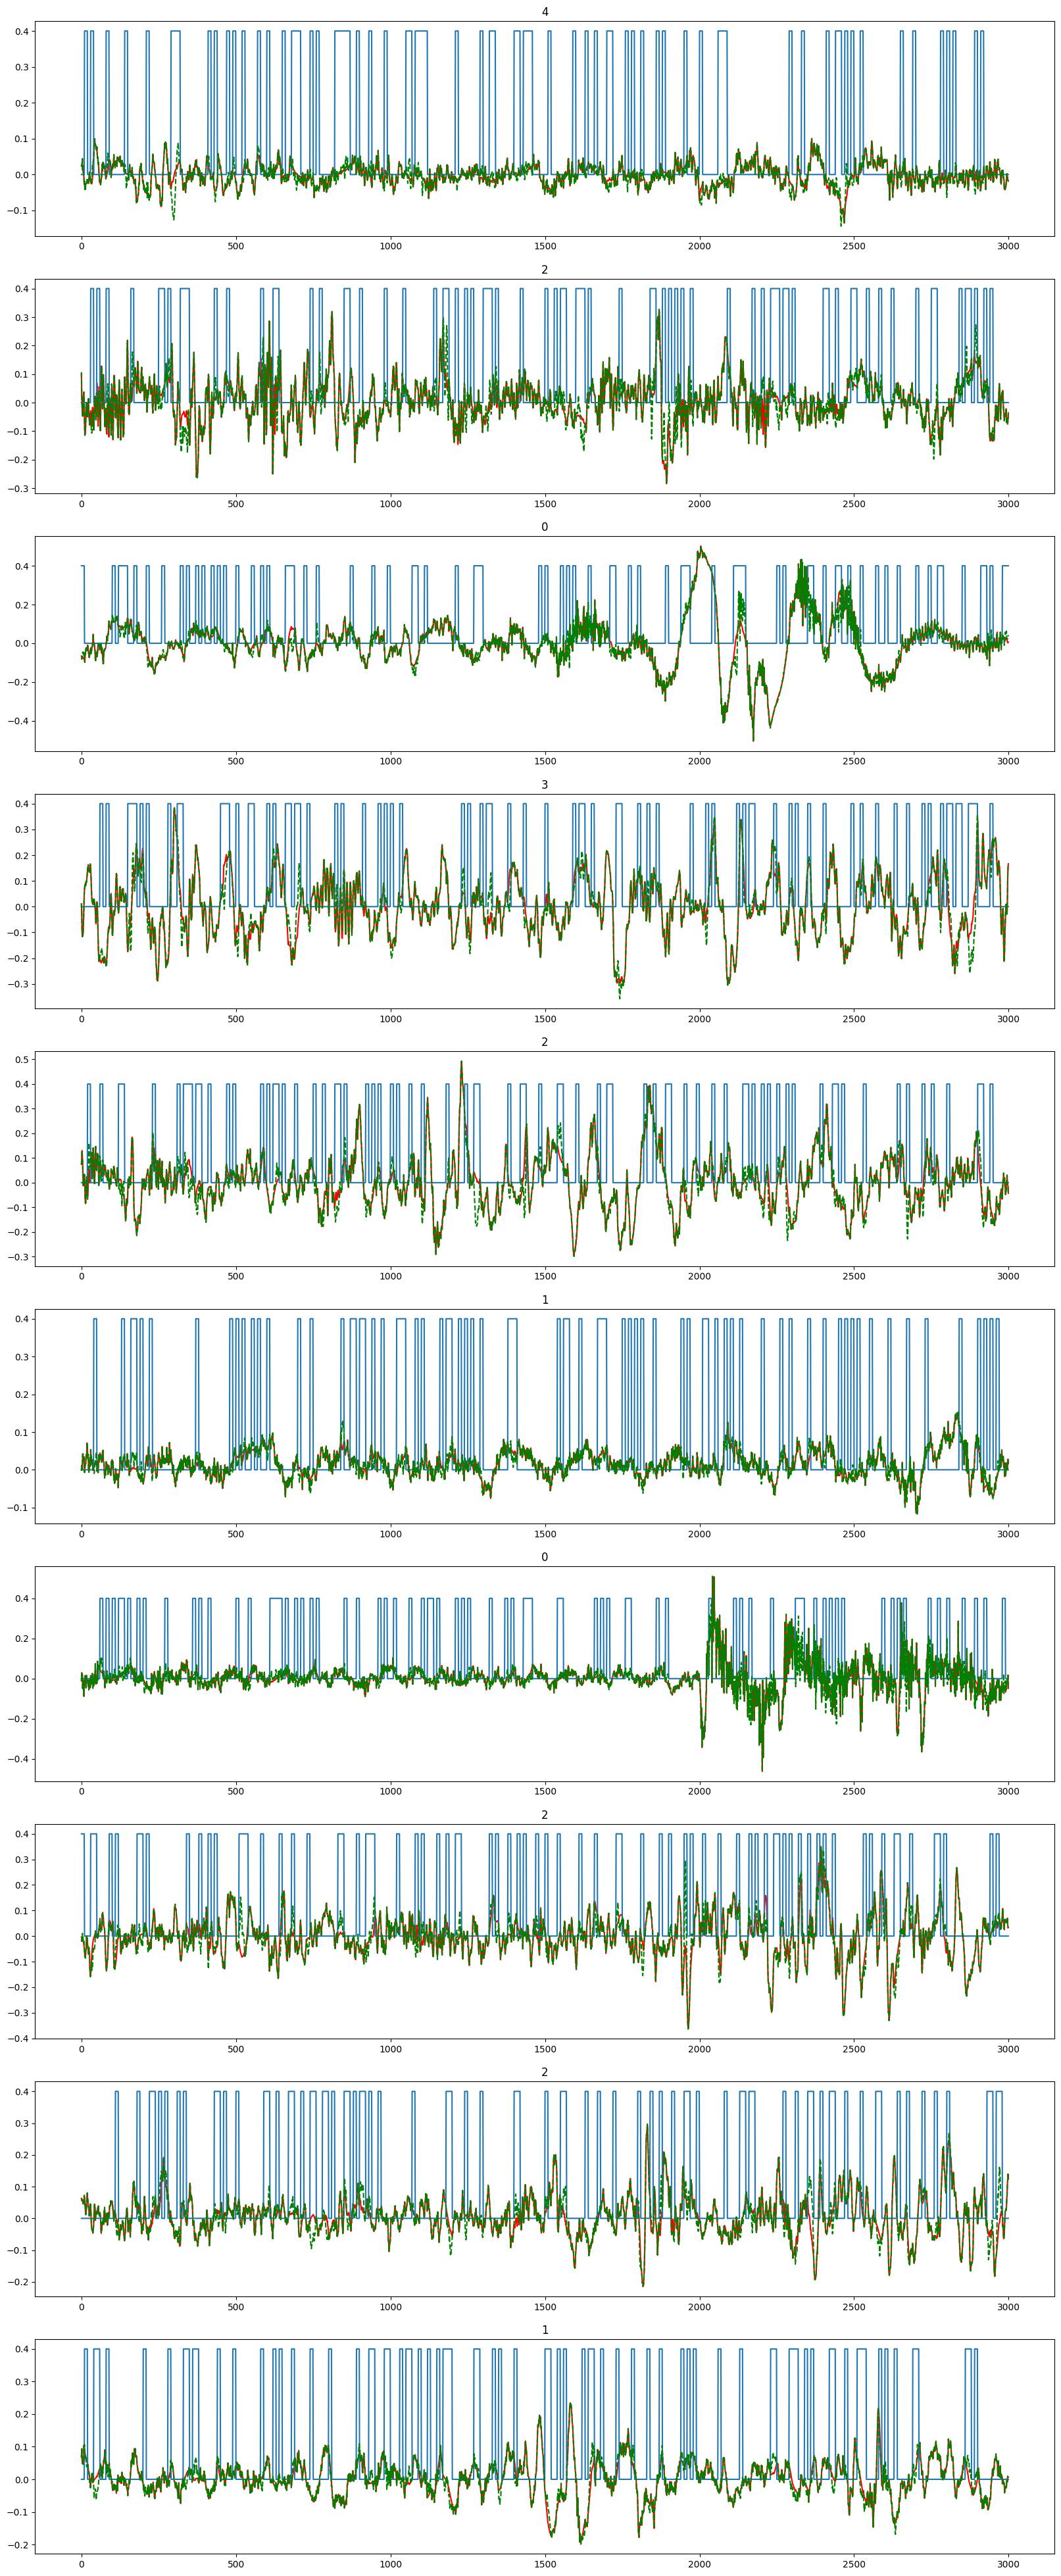

In [42]:
fig = plt.figure(figsize=(20, 50))
ch = 0
d = 10
for i in range(10):
    plt.subplot(10, 1, i + 1)
    plt.plot(samp[i+d][ch], c='r')
    plt.plot(mask[i+d][ch]*0.4)
    plt.plot(orig[i+d][ch], 'g--')
    plt.title(lab[i+d])

In [43]:
1/0

ZeroDivisionError: division by zero

In [ ]:
samp.shape, sdata.shape

((2500, 1, 3000), (137521, 3000))

In [ ]:
length = 1000
d=0
all = np.concatenate((samp.squeeze()[:,d,:length], sdata[:,:length]), axis=0)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
tsne = TSNE(n_components=2, perplexity=10, n_iter=2000,
            init='random').fit_transform(all)


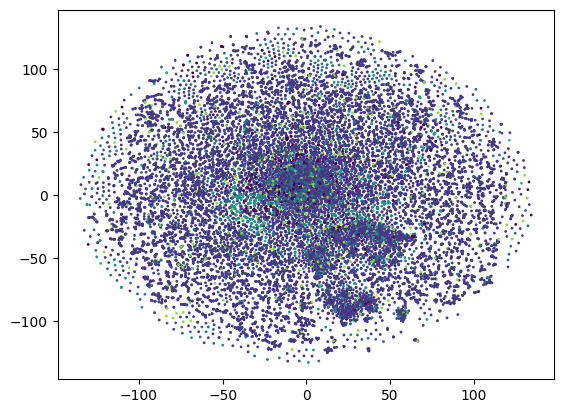

In [ ]:
plt.scatter(tsne[samp.shape[0]:, 0], tsne[samp.shape[0]:, 1], c=datal, s=1, cmap='viridis');

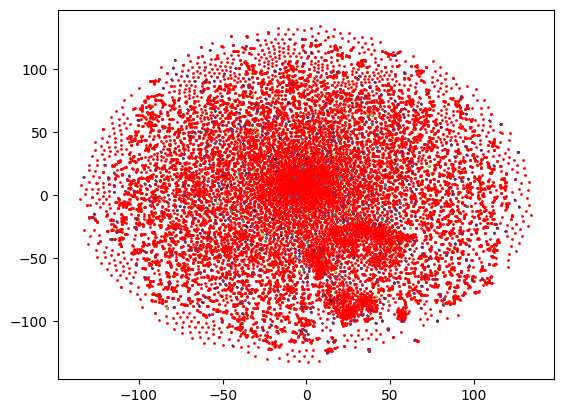

In [ ]:
plt.scatter(tsne[samp.shape[0]:, 0], tsne[samp.shape[0]:, 1], c='r', s=1)
plt.scatter(tsne[:samp.shape[0], 0], tsne[:samp.shape[0], 1],c=lab,cmap='viridis', s=1, marker='x');